In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df= pd.read_csv('/content/DFORE164s.zip', compression='zip', low_memory=False)
df.event_timestamp= pd.to_datetime(df.event_timestamp)
df.room_id= df.room_id.str.upper()

In [3]:
print('Incoming: ', df.shape)
df1=df.loc[~df.room_id.str.contains('TEST')]
df1=df1.loc[~df1.room_id.str.contains('TRAIN')]
df1=df1.loc[~df1.room_id.str.contains('KYLE')]
df1=df1.loc[~df1.room_id.str.contains('THEO')]
print('After Removing Suspects: ', df1.shape)
df1.sort_values(['room_id', 'event_timestamp'], axis=0, ascending= False, inplace=True)

Incoming:  (1116664, 5)
After Removing Suspects:  (1114670, 5)


In [4]:
len(df1.vendor_location_id.unique())

8326

In [5]:
len(df1.room_id.unique())

13087

In [6]:
df1.event_timestamp.max()

Timestamp('2021-11-23 17:16:59')

In [7]:
df1.room_id.value_counts().describe().T

count    13087.000000
mean        85.173837
std        225.992097
min          1.000000
25%         19.000000
50%         49.000000
75%         92.000000
max       7513.000000
Name: room_id, dtype: float64

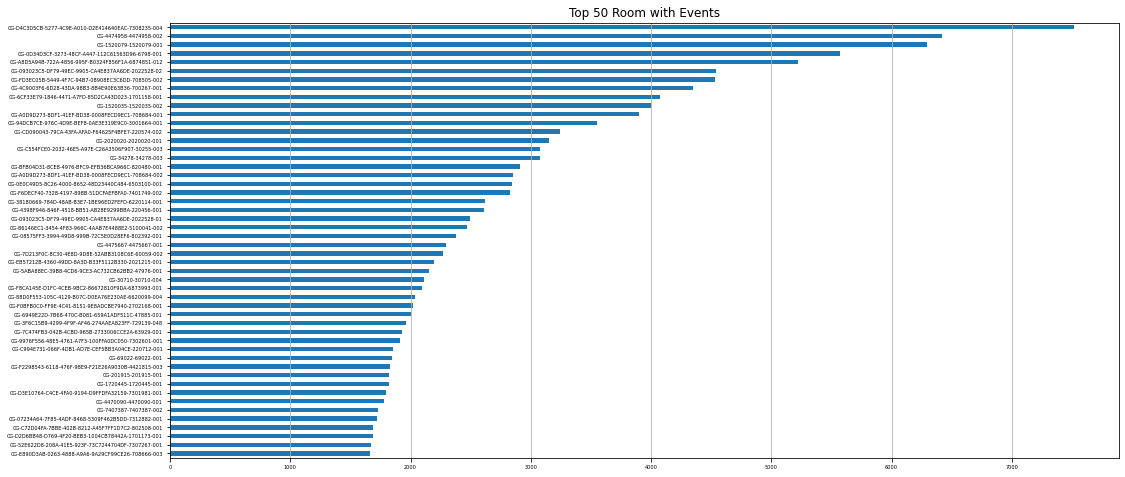

In [8]:
TopCnt= df1.room_id.value_counts().head(50).sort_values()
TopCnt.plot(kind='barh', fontsize=5, figsize=(17,8), title= 'Top 50 Room with Events').grid(axis='x')

In [9]:
rm= df1.room_id.value_counts()[df1.room_id.value_counts()== 5].index[0]

In [10]:
rm1= df1.room_id.value_counts()[df1.room_id.value_counts()== 1].index.tolist()

In [11]:
len(rm1)

269

In [12]:
df1.loc[df1.room_id==rm1[100]]

,room_id,vendor_location_id,client_account_id,event_type,event_timestamp
313849,CG-3508DD70-EEB2-4F80-A62F-4CF2A1DB514D-620046...,3508dd70-eeb2-4f80-a62f-4cf2a1db514d,620046,CONNECTED,2021-11-19 17:05:55


In [13]:
df1=df1.loc[~df1.room_id.isin(rm1)]

In [14]:
df1.loc[:,'last_event_timestamp']= df1.groupby('room_id')['event_timestamp'].shift(-1)
df1.loc[:,'last_event_type']= df1.groupby('room_id')['event_type'].shift(-1)

In [15]:
df1.loc[:, 'TimeLength']= df1.event_timestamp- df1.last_event_timestamp
df1.loc[:,'TimeLengthH']= df1.TimeLength.astype('timedelta64[s]')/3600

In [16]:
df1.dropna(inplace= True)

In [17]:
sum(df1.room_id.isin(rm1))

0

In [18]:
df1.groupby(['last_event_type', 'event_type']).size()

last_event_type  event_type  
CONNECTED        CONNECTED        88002
                 DISCONNECTED    506016
DISCONNECTED     CONNECTED       505094
                 DISCONNECTED      2471
dtype: int64

In [19]:
df1.loc[(df1.last_event_type== 'DISCONNECTED') & (df1.event_type== 'DISCONNECTED'), 'State']= 'DISCONNECTED'
df1.loc[(df1.last_event_type== 'DISCONNECTED') & (df1.event_type== 'CONNECTED'), 'State']= 'DISCONNECTED'
df1.loc[(df1.last_event_type== 'CONNECTED') & (df1.event_type== 'CONNECTED'), 'State']= 'CONNECTED'
df1.loc[(df1.last_event_type== 'CONNECTED') & (df1.event_type== 'DISCONNECTED'), 'State']= 'CONNECTED'

In [20]:
cbnds=df1.loc[df1.State=='CONNECTED', 'TimeLengthH'].describe(percentiles= [.05,.95]).loc[['5%', '95%']].values
dbnds=df1.loc[df1.State=='DISCONNECTED', 'TimeLengthH'].describe(percentiles= [.05,.95]).loc[['5%', '95%']].values

In [21]:
dbnds[1]

1.9816111111111079

In [22]:
df2=pd.concat([df1.loc[df1.State=='DISCONNECTED'].loc[df1.loc[df1.State=='DISCONNECTED', 'TimeLengthH'].between(dbnds[0], dbnds[1])],
df1.loc[df1.State=='CONNECTED'].loc[df1.loc[df1.State=='CONNECTED', 'TimeLengthH'].between(cbnds[0], cbnds[1])]], axis=0)

In [23]:
print(cbnds)
print(dbnds)

[8.58333333e-02 1.91887028e+02]
[0.02194444 1.98161111]


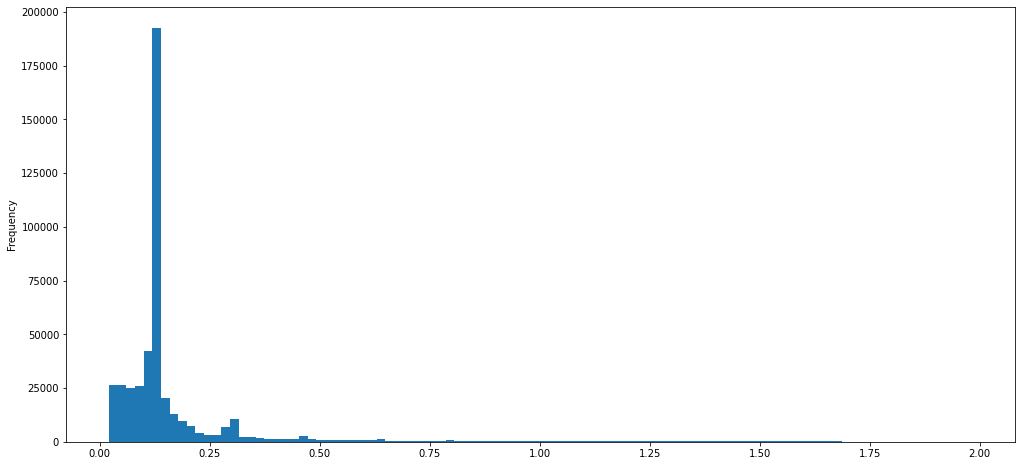

In [24]:

df2.loc[df2.State=='DISCONNECTED', 'TimeLengthH'].plot(kind='hist', figsize=(17,8), bins=100)

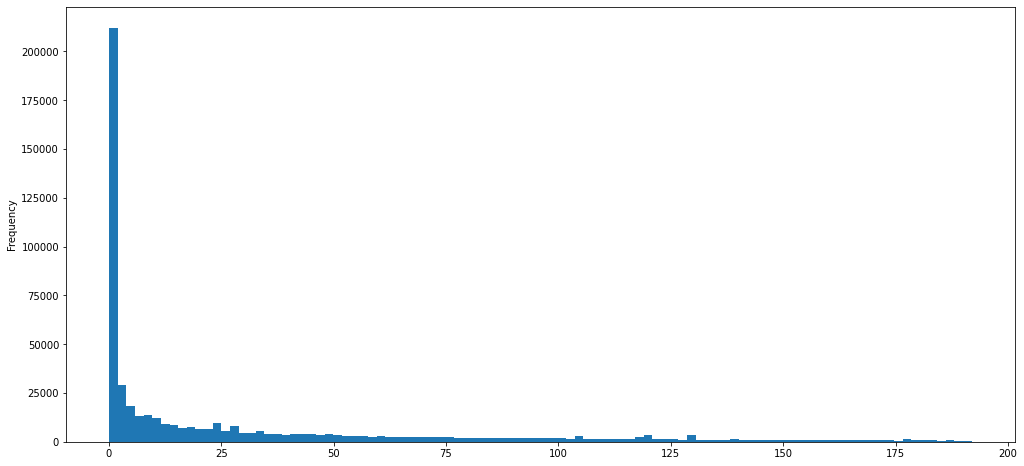

In [25]:
df2.loc[df2.State=='CONNECTED', 'TimeLengthH'].plot(kind='hist', figsize=(17,8), bins=100)

In [26]:
df2.groupby('State')['TimeLengthH'].describe()

,count,mean,std,min,25%,50%,75%,max
State,,,,,,,,
CONNECTED,534625.0,30.335592,44.983200,0.085833,0.380833,6.841111,43.043611,191.886944
DISCONNECTED,456851.0,0.184122,0.236346,0.021944,0.108333,0.130000,0.141667,1.981389


In [27]:
df2.columns

Index(['room_id', 'vendor_location_id', 'client_account_id', 'event_type',
       'event_timestamp', 'last_event_timestamp', 'last_event_type',
       'TimeLength', 'TimeLengthH', 'State'],
      dtype='object')

In [28]:
df2['DoW']=df2.last_event_timestamp.dt.dayofweek
df2['ToD']= df2.last_event_timestamp.dt.hour
df2['EventDate']= df2.last_event_timestamp.dt.date

In [29]:
df3= df2.loc[df2.State== 'DISCONNECTED']

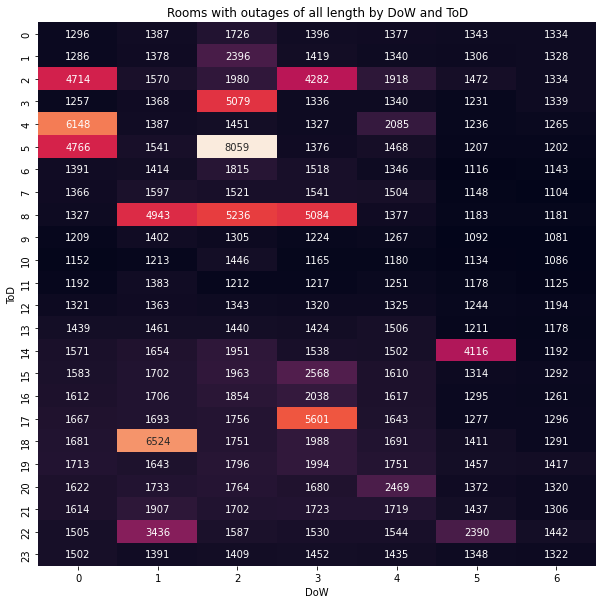

In [30]:
fig, ax = plt.subplots(figsize=(10,10))  
ax.set_title('Rooms with outages of all length by DoW and ToD')
sns.heatmap(pd.crosstab(df3.ToD, df3.DoW, df3.room_id, aggfunc='nunique'), ax=ax, fmt='d', annot=True, cbar=False)

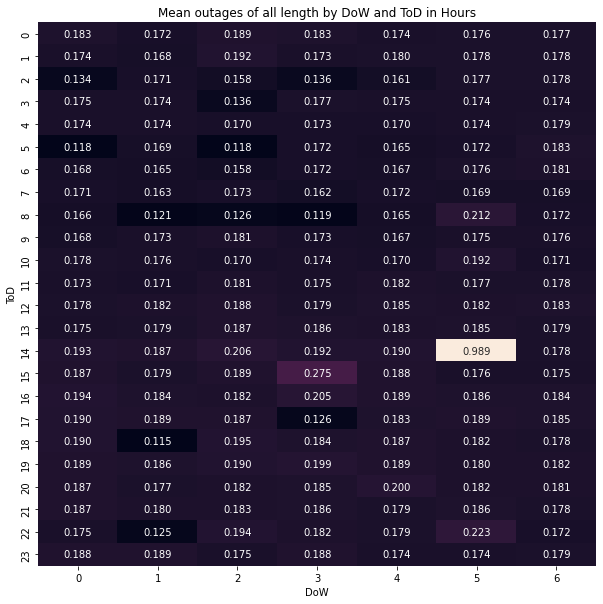

In [31]:
fig, ax = plt.subplots(figsize=(10,10))  
ax.set_title('Mean outages of all length by DoW and ToD in Hours')
sns.heatmap(pd.crosstab(df3.ToD, df3.DoW, df3.TimeLengthH, aggfunc='mean'), ax=ax, fmt='.3f', annot=True, cbar=False)

In [32]:
met_dict= {'StateCount': len}

In [33]:
df4=pd.pivot_table(df2, index=['room_id', 'EventDate'], columns=['State'], values='TimeLengthH', 
               aggfunc={'TimeLengthH': [np.sum, len]}, fill_value=0)

In [37]:
df41=df4['sum']['DISCONNECTED'].reset_index()

In [44]:
df41.EventDate= pd.to_datetime(df41.EventDate)

In [50]:
df41= df41.loc[df41.EventDate.between('06/23/2021', '11/22/2021')]

In [62]:
df42= df41.groupby('EventDate').agg({'room_id': pd.Series.nunique, 'DISCONNECTED': np.sum}).rename(columns={'room_id': 'Rooms Affected', 'DISCONNECTED': 'TotalOutage- Hours'})

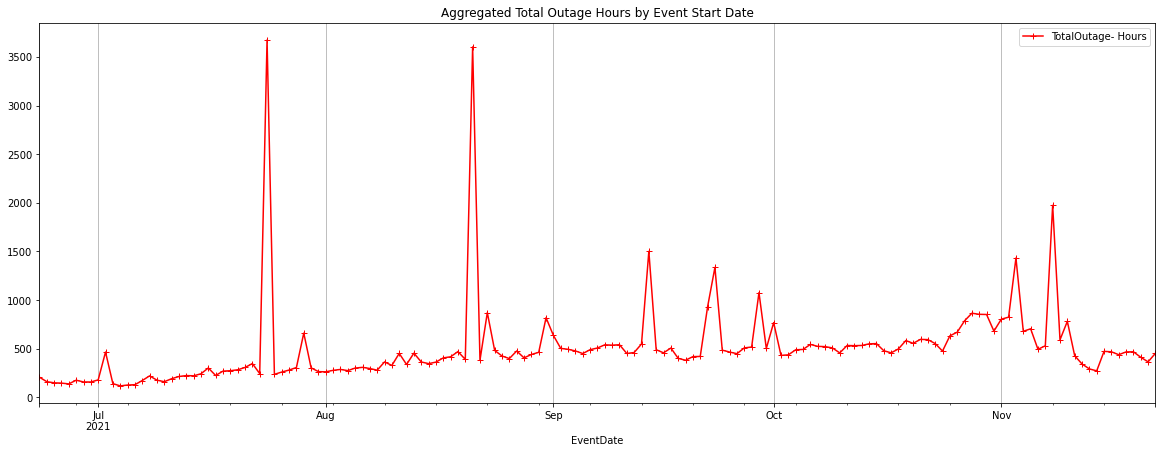

In [75]:
fig, ax1 = plt.subplots(figsize=(20, 7), sharex=True)
# df42['Rooms Affected'].plot(kind='bar', color='y', ax=ax1)
df42['TotalOutage- Hours'].plot(kind='line', marker='+', color= 'red', ax=ax1, title= 'Aggregated Total Outage Hours by Event Start Date', legend= True).grid(axis='x')
plt.show()

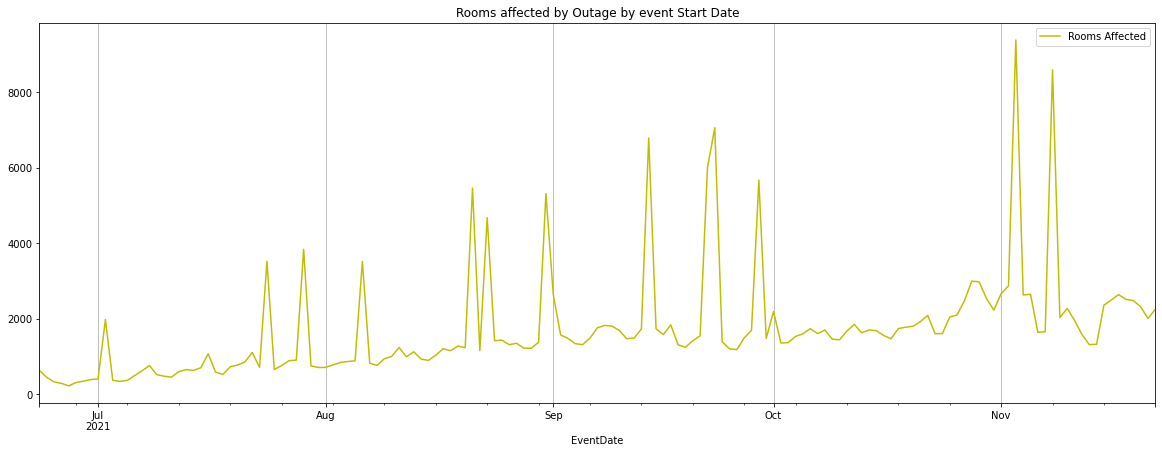

In [77]:
fig, ax1 = plt.subplots(figsize=(20, 7), sharex=True)
df42['Rooms Affected'].plot(kind='line', color='y', ax=ax1, title= 'Rooms affected by Outage by event Start Date', legend= True).grid(axis='x')
# df42['TotalOutage- Hours'].plot(kind='line', marker='+', color= 'red', ax=ax1, title= 'Aggregated Total Outage Hours by Event Start Date', legend= True).grid(axis='x')
plt.show()

In [80]:
df42['MeanOutage']= df42['TotalOutage- Hours']/ df42['Rooms Affected']

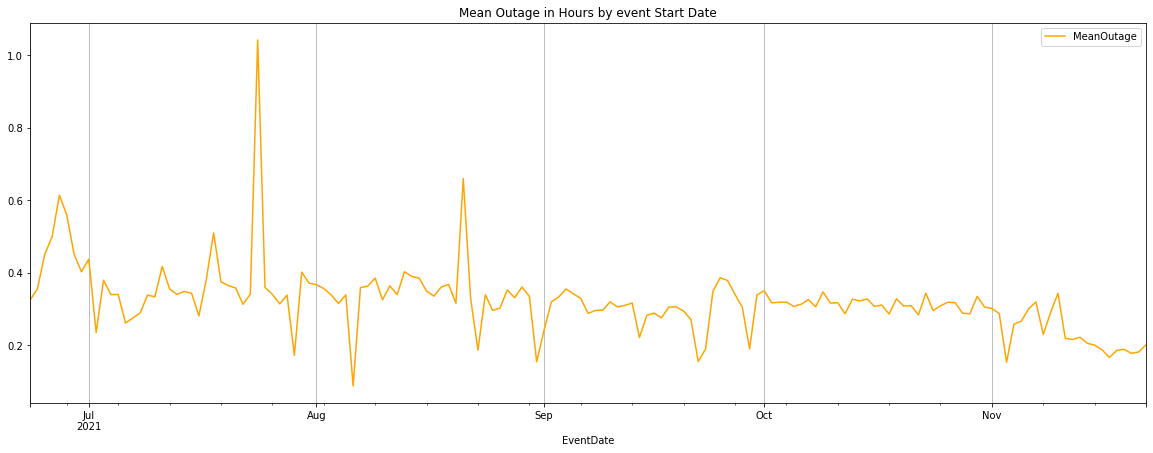

In [82]:
fig, ax1 = plt.subplots(figsize=(20, 7), sharex=True)
df42['MeanOutage'].plot(kind='line', color='orange', ax=ax1, title= 'Mean Outage in Hours by event Start Date', legend= True).grid(axis='x')
# df42['TotalOutage- Hours'].plot(kind='line', marker='+', color= 'red', ax=ax1, title= 'Aggregated Total Outage Hours by Event Start Date', legend= True).grid(axis='x')
plt.show()